In [3]:
import pandas as pd
df = pd.read_parquet('../data_acq/objective_data.parquet')
print('unique matches: ', df['matchId'].nunique())
df

unique matches:  56217


,damageTypeRatio,goldDifference,averageAllyLvl,averageEnemyLvl,averageAllyToFountain,averageEnemytoFountain,alliedDragons,enemyDragons,alliedGrubs,enemyGrubs,...,enemyCCScore,isSquishy,vsSquishy,won,objective,team,matchId,patch,rank,region
0,6.115942,-1634.0,5.0,4.8,10358.471587,9639.596728,0,0,0,0,...,6,0,0,0,grub,200,KR_7558776166,15.5,platinum,kr
1,6.115942,-1634.0,5.0,5.4,10358.471587,9639.596728,0,0,1,0,...,6,0,0,0,grub,200,KR_7558776166,15.5,platinum,kr
2,6.115942,-1634.0,5.0,5.4,10358.471587,9639.596728,0,0,2,0,...,6,0,0,0,grub,200,KR_7558776166,15.5,platinum,kr
3,0.816602,3760.0,6.8,6.0,10360.075432,8201.171149,0,0,0,3,...,12,0,0,1,WATER_DRAGON,100,KR_7558776166,15.5,platinum,kr
4,0.695771,4738.4,7.8,6.8,10305.428423,9333.558868,1,0,0,3,...,12,0,0,1,grub,100,KR_7558776166,15.5,platinum,kr
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2144237,1.450616,1044.0,10.2,9.8,10616.024193,8930.446637,2,0,6,0,...,10,0,1,1,botT1,100,KR_7576353028,15.6,grandmaster,kr
2144238,1.401222,1612.0,10.8,10.0,9899.570191,8454.252144,2,0,6,0,...,10,0,1,1,riftHerald,100,KR_7576353028,15.6,grandmaster,kr
2144239,1.401222,2999.4,11.0,10.4,9899.570191,8454.252144,2,0,6,0,...,10,0,1,1,midT1,100,KR_7576353028,15.6,grandmaster,kr
2144240,1.401222,3499.4,11.2,10.4,9899.570191,8454.252144,2,0,6,0,...,10,0,1,1,midT2,100,KR_7576353028,15.6,grandmaster,kr


count    2.144242e+06
mean     1.862541e+01
std      8.148138e+00
min      5.301517e+00
25%      1.217528e+01
50%      1.775854e+01
75%      2.453922e+01
max      6.486793e+01
Name: minutesElapsed, dtype: float64

<Axes: >

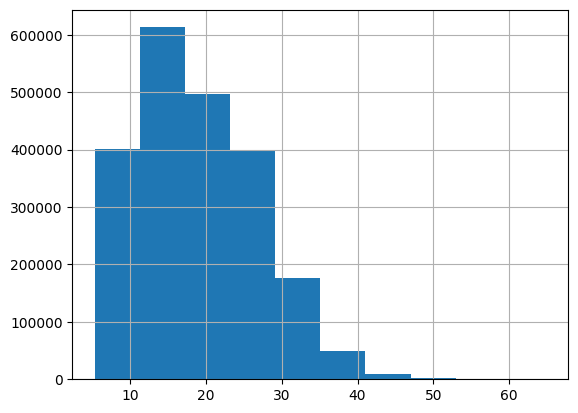

In [6]:
display(df['minutesElapsed'].describe())
df['minutesElapsed'].hist()

In [13]:
import pandas as pd
def prediction_columns(df: pd.DataFrame):
    return df.drop(columns=['won', 'objective', 'matchId', 'patch', 'region'])

def calc_ece(model, df):
    from sklearn.calibration import calibration_curve
    import numpy as np
    
    y_preds = [item[1] for item in model.predict_proba(prediction_columns(df))]
    ratio_true_1s, avg_preds = calibration_curve(y_true=df['won'], y_prob=y_preds, n_bins=30)
    bin_counts = np.histogram(y_preds, bins=30)[0]
    ece = np.sum(bin_counts / len(df['won']) * np.abs(ratio_true_1s - avg_preds))
    
    return ece

### Depth Grid Search

In [12]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool, cv
import scipy.stats as st
import pickle

df = pd.read_parquet('../data_acq/objective_data.parquet')

match_list = df['matchId'].unique()

for depth in [4,6,8]:
    for rate in [.01, .05, .1]:
        train_matches, test_matches = train_test_split(match_list, test_size=.5)

        df_train = df[df['matchId'].isin(train_matches)]
        df_test = df[df['matchId'].isin(test_matches)]

        train_matches, test_matches = train_test_split(match_list, test_size=.5)

        df_train = df[df['matchId'].isin(train_matches)]
        df_test = df[df['matchId'].isin(test_matches)]

        X_train = prediction_columns(df_train)
        y_train = df_train['won']

        X_test = prediction_columns(df_test)
        y_test = df_test['won']

        ece_scores = []
        for i in range(10):   
            
            model = CatBoostClassifier(cat_features=['soulType', 'team', 'rank'],
                        depth=depth, 
                        learning_rate=rate, 
                        early_stopping_rounds=50,
                        loss_function='Logloss',
                        eval_metric='Logloss',
                        task_type="GPU",
                        devices='0',
                        verbose=False)
            model.fit(X_train, y_train, eval_set=(X_test, y_test))

            y_preds = [item[1] for item in model.predict_proba(prediction_columns(df))]
            ratio_true_1s, avg_preds = calibration_curve(y_true=df['won'], y_prob=y_preds, n_bins=30)
            bin_counts = np.histogram(y_preds, bins=30)[0]
            ece = np.sum(bin_counts / len(df['won']) * np.abs(ratio_true_1s - avg_preds))
            ece_scores.append(ece)
        
        
        mean_ece = np.mean(ece_scores)
        print(f"Rate: {rate} | Depth: {depth} | Mean ECE: {mean_ece:.4f}")


Rate: 0.01 | Depth: 4 | Mean ECE: 0.0053
Rate: 0.05 | Depth: 4 | Mean ECE: 0.0060
Rate: 0.1 | Depth: 4 | Mean ECE: 0.0036
Rate: 0.01 | Depth: 6 | Mean ECE: 0.0044
Rate: 0.05 | Depth: 6 | Mean ECE: 0.0053
Rate: 0.1 | Depth: 6 | Mean ECE: 0.0040
Rate: 0.01 | Depth: 8 | Mean ECE: 0.0070
Rate: 0.05 | Depth: 8 | Mean ECE: 0.0062
Rate: 0.1 | Depth: 8 | Mean ECE: 0.0064


### Backwards Selection

In [7]:
import pandas as pd
import pickle
with open("low_ece.pkl", "rb") as f:
    best_model = pickle.load(f)

test_set = pd.read_parquet('test_set.parquet')
feat_imp = pd.Series(best_model.get_feature_importance(), prediction_columns(test_set).columns).sort_values(ascending=False)
feat_imp

goldDifference            42.126387
alliedDragons              9.899739
enemyDragons               7.591043
avgEnemyRespawn            6.758658
atakhan                    6.320431
averageAllyLvl             2.903305
averageEnemyLvl            2.808478
avgAlliedRespawn           2.108393
damageTypeRatio            1.800615
CCScore                    1.765591
enemyCCScore               1.609082
tillEnemyNT2               1.571528
alliedGrubs                0.995233
tillEnemyMidInhib          0.958692
team                       0.842095
untilBaronExp              0.831600
averageEnemytoFountain     0.818124
enemyGrubs                 0.708210
averageAllyToFountain      0.574363
topTurrets                 0.558593
untilGrubsSpawn            0.512748
vsSquishy                  0.512039
rank                       0.482846
tillEnemyNT1               0.454888
hasSoul                    0.444025
untilBaronSpawn            0.413967
untilDragonSpawn           0.361578
isSquishy                  0

In [46]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split

match_list = df['matchId'].unique()
for i in range(1,11):
    train_matches, test_matches = train_test_split(match_list, test_size=.5)

    train_set = df[df['matchId'].isin(train_matches)]
    test_set = df[df['matchId'].isin(test_matches)]

    drop_cols = feat_imp[-i:].index.tolist()
    train_dropped = train_set.drop(columns=drop_cols)
    test_dropped = test_set.drop(columns=drop_cols)

    model = CatBoostClassifier(cat_features=['soulType', 'team', 'rank'],
                        depth=4, 
                        learning_rate=0.05, 
                        early_stopping_rounds=50,
                        loss_function='Logloss',
                        eval_metric='Logloss',
                        task_type="GPU",
                        devices='0',
                        verbose=False
                        )
    model.fit(prediction_columns(train_dropped), train_dropped['won'], eval_set=(prediction_columns(test_dropped), test_dropped['won']))

    print(f'{i} features removed ece:', calc_ece(model, test_dropped))

1 features removed ece: 0.006020615388908992
2 features removed ece: 0.0053114675276312254
3 features removed ece: 0.007134851544954594
4 features removed ece: 0.004185708058620033
5 features removed ece: 0.005820601986603816
6 features removed ece: 0.005531706064095342
7 features removed ece: 0.004035791966854407
8 features removed ece: 0.00753314059410404
9 features removed ece: 0.006170880830052941
10 features removed ece: 0.006360314668143345


In [ ]:
"""
I dont think this is helpful ^^^ I kept full feature set
"""

### Best model

In [ ]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool, cv
import scipy.stats as st
import seaborn as sns

match_list = df['matchId'].unique()
train_matches, test_matches = train_test_split(match_list, test_size=.5)

df_train = df[df['matchId'].isin(train_matches)]
df_test = df[df['matchId'].isin(test_matches)]

X_train = df_train.drop(columns=['won', 'objective', 'matchId', 'patch', 'region'])
y_train = df_train['won']

X_test = df_test.drop(columns=['won', 'objective', 'matchId', 'patch', 'region'])
y_test = df_test['won']


model = CatBoostClassifier(cat_features=['soulType', 'team', 'rank'],
                    depth=4, 
                    learning_rate=0.05, 
                    early_stopping_rounds=50,
                    loss_function='Logloss',
                    eval_metric='Logloss',
                    task_type="GPU",
                    devices='0',
                    verbose=False)
model.fit(X_train, y_train, eval_set=(X_test, y_test))

y_preds = [item[1] for item in model.predict_proba(X_test)]
ratio_true_1s, avg_preds = calibration_curve(y_true=y_test, y_prob=y_preds, n_bins=30)

bin_errors = ratio_true_1s - avg_preds
bin_counts = np.histogram(y_preds, bins=30)[0]
ece = np.sum(bin_counts / len(y_test) * np.abs(bin_errors))
print(ece)

0.0034693440060993416


ECE:  0.0034693440060993416


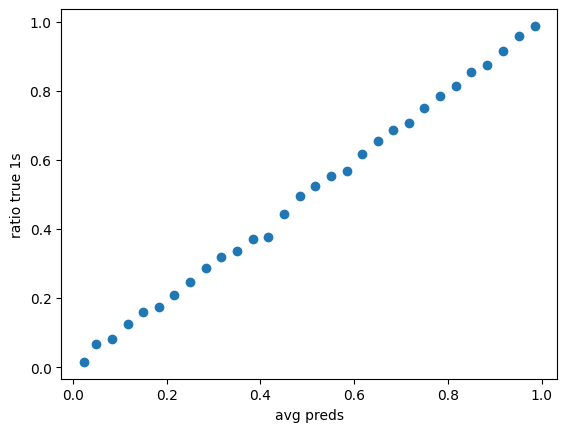

In [209]:
print('ECE: ', ece)
plt.scatter(avg_preds, ratio_true_1s)
plt.xlabel("avg preds")
plt.ylabel("ratio true 1s")
plt.show()

### Below we fail to reject normality for error across the different bins in the model

P-value: 0.6037644899072733


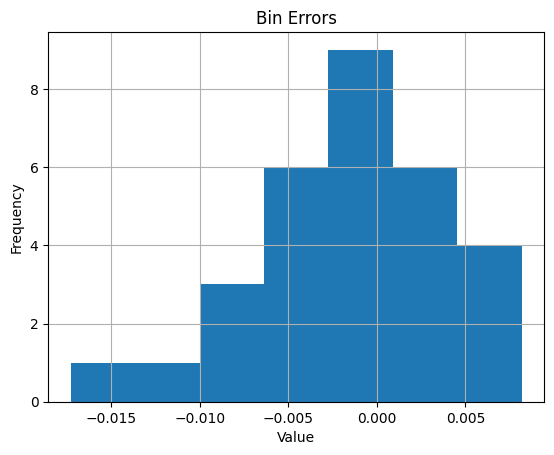

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import shapiro
import pickle
from sklearn.calibration import calibration_curve
with open('low_ece.pkl', 'rb') as file:
    model = pickle.load(file)
    
df_test = pd.read_parquet('test_set.parquet')

y_preds = [item[1] for item in model.predict_proba(prediction_columns(df_test))]
ratio_true_1s, avg_preds = calibration_curve(y_true=df_test['won'], y_prob=y_preds, n_bins=30)

bin_errors = ratio_true_1s - avg_preds

stat, p = shapiro(bin_errors)

print(f"P-value: {p}")
plt.hist(bin_errors, bins=7)
plt.title("Bin Errors")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.grid()
plt.show()


### below we split the testing set 30 ways and find distribution of error FOR EACH bucket. We fail to reject normally distributed error for all buckets.

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import shapiro
import pickle
from sklearn.calibration import calibration_curve
with open('low_ece.pkl', 'rb') as file:
    best_model = pickle.load(file)

df_test = pd.read_parquet('test_set.parquet')
subsets = np.array_split(df_test.sample(frac=1), 30)

model_errors = []
for sub in subsets:
    y_preds = [item[1] for item in best_model.predict_proba(prediction_columns(sub))]
    ratio_true_1s, avg_preds = calibration_curve(y_true=sub['won'], y_prob=y_preds, n_bins=30)

    bin_errors = ratio_true_1s - avg_preds
    model_errors.append(bin_errors)

data = pd.DataFrame(model_errors, columns=list(range(1,31)))

def test_norm_c0(sample: pd.Series):
    stat, p = shapiro(sample)
    if p > .05:
        norm = '✅normal'
    else:
        norm = '❌ not normal'

    
    return f'{norm}'

data.apply(test_norm_c0, axis=0)

c:\Users\Luke\Desktop\SELF_LEARNING\LoL_Objective_Strength\.venv\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


1     ✅normal
2     ✅normal
3     ✅normal
4     ✅normal
5     ✅normal
6     ✅normal
7     ✅normal
8     ✅normal
9     ✅normal
10    ✅normal
11    ✅normal
12    ✅normal
13    ✅normal
14    ✅normal
15    ✅normal
16    ✅normal
17    ✅normal
18    ✅normal
19    ✅normal
20    ✅normal
21    ✅normal
22    ✅normal
23    ✅normal
24    ✅normal
25    ✅normal
26    ✅normal
27    ✅normal
28    ✅normal
29    ✅normal
30    ✅normal
dtype: object

### Simulate objective capture and find win delta

In [13]:
def simulate_obj(row):
    obj = row['objective']

    if obj in ['EARTH_DRAGON', 'CHEMTECH_DRAGON', 'WATER_DRAGON', 
            'FIRE_DRAGON', 'AIR_DRAGON', 'HEXTECH_DRAGON']:
        row['alliedDragons'] += 1
        row['untilDragonSpawn'] = 300
        row['goldDifference'] += 25

    elif obj in ['Chemtech_dragon_soul', 'Cloud_dragon_soul', 'Hextech_dragon_soul',
                'Mountain_dragon_soul', 'Ocean_dragon_soul', 'Infernal_dragon_soul']:
        row['alliedDragons'] += 1
        row['untilDragonSpawn'] = np.nan
        row['untilElderSpawn'] = 360
        row['goldDifference'] += 25
        row['hasSoul'] = 1


    elif obj == 'atakhan':
        row['atakhan'] = 1
        row['goldDifference'] += 275

    elif obj == 'riftHerald':
        row['killedHerald'] = 1
        row['goldDifference'] += 200


    elif obj == 'nexusTurret':
        if row['tillEnemyNT1'] == 0:
            row['tillEnemyNT1'] = 180
        else:
            row['tillEnemyNT2'] = 180
        row['goldDifference'] += 250

    elif obj == 'baron':
        row['untilBaronExp'] = 180
        row['untilBaronSpawn'] = 360
        row['goldDifference'] += 1525

    elif obj == 'midInhib':
        row['tillEnemyMidInhib'] = 300
    
    elif obj == 'topInhib':
        row['tillEnemyTopInhib'] = 300

    elif obj == 'botInhib':
        row['tillEnemyBotInhib'] = 300

    elif obj in ['midT1', 'midT2', 'midT3']:
        row['enemyMidTurrets'] -= 1
        if 'T1' in obj:
            row['goldDifference'] += 500
        if 'T2' in obj:
            row['goldDifference'] += 550
        if 'T3' in obj:
            row['goldDifference'] += 500
    
    elif obj in ['botT1', 'botT2', 'botT3']:
        row['enemyBotTurrets'] -= 1
        if 'T1' in obj:
            row['goldDifference'] += 500
        if 'T2' in obj:
            row['goldDifference'] += 800
        if 'T3' in obj:
            row['goldDifference'] += 500
    
    elif obj in ['topT1', 'topT2', 'topT3']:
        row['enemytopTurrets'] -= 1
        if 'T1' in obj:
            row['goldDifference'] += 500
        if 'T2' in obj:
            row['goldDifference'] += 800
        if 'T3' in obj:
            row['goldDifference'] += 500
    
    elif obj == 'elder':
        row['untilElderExp'] = 150
        row['untilElderSpawn'] = 360
        row['goldDifference'] += 1350

    
    elif obj == 'grub':
        row['alliedGrubs'] += 1
        if (row['alliedGrubs'] + row['enemyGrubs']) % 3 == 0: 
            if row['minutesElapsed'] < 11.75:
                row['untilGrubsSpawn'] = 240
            else:
                row['untilGrubsSpawn'] = np.nan
        row['goldDifference'] += 25
        
    elif obj == 'feats':
        row['featsOfStrength'] = 1

    return row

from catboost import CatBoostClassifier
def find_win_deltas(df: pd.DataFrame, model: CatBoostClassifier) -> pd.DataFrame:
    df = df.copy(deep=True)

    df['pre_pred'] = [item[1] for item in model.predict_proba(prediction_columns(df))]
    
    post_df = df.apply(simulate_obj, axis=1)

    df['post_pred'] = [item[1] for item in model.predict_proba(prediction_columns(post_df))] 
    
    differences = df['post_pred'] - df['pre_pred']

    df['win_delta'] = differences

    return df


### Calculate mean and confidence interval for each objective based on a subset of the data

#### merge bins until sufficient obs

In [ ]:
def merge_small_bins(df: pd.DataFrame) -> pd.DataFrame:
    merged = []
    bin_edges = np.linspace(0, 1, 31)
    for obj, group in df.groupby('objective'):

        group = group.copy()
        group['bucket'] = pd.cut(group['pre_pred'], bins=bin_edges)
        counts = group['bucket'].value_counts().sort_index()

        bins = counts.index.tolist()
        merged_bins = []
        current_bin = None
        current_count = 0

        for b in bins:
            if current_bin is None:
                current_bin = b
                current_count = counts[b]  
            else:
                current_count += counts[b]
            
            if current_count < 30:
                continue
            new_bin = pd.Interval(left=current_bin.left, right=b.right, closed='right')
            merged_bins.append((new_bin, current_count))
            current_bin = None
            current_count = 0
        
        if current_bin is not None:
            new_bin = pd.Interval(left=current_bin.left, right=current_bin.right, closed='right')
            merged_bins.append((new_bin, current_count))
        
        edges = sorted(set([bin[0].left for bin in merged_bins] + [merged_bins[-1][0].right]))
        group['merged_bucket'] = pd.cut(group['pre_pred'], bins=edges, include_lowest=True)

        merged.append(group)
    
    return pd.concat(merged)

#### Calculations
$$N_j = \text{total num observations across objective}$$
$$n_{j,b} = \text{num observations in bucket b for objective j}$$
$$\overline{\triangle W_{j,b}} = \text{average win probability added in bucket b for objective j}$$
$$s^2_{j,b} = \text{in bucket b for objective j}$$
##### For mean estimate:
$$\widehat{\triangle W_j} = \frac{1}{N_j}\sum_b n_{j,b} \cdot \overline{\triangle W_{j,b}}$$

##### For variance:
$$\widehat{Var}(\widehat{\triangle W_j}) = \frac{1}{N_j^2}\sum_b n_{j,b} \cdot s^2_{j,b}$$

##### Confidence interval:
$$  \widehat{\triangle W_j} \pm \sqrt{\widehat{Var}}\cdot z_{.0975}$$


In [12]:
def calc_mean_ci(bucket_stats: pd.DataFrame) -> dict:
    stats = {}
    for obj, group in bucket_stats.groupby('objective'):

        n_observations_obj = group['n'].sum()
        means = group['m']
        n_observations_buckets = group['n']

        bucket_weighted_means = np.sum(n_observations_buckets * means) / n_observations_obj

        # calculate ci
        bucket_variences = group['var'] 
        objective_varience = np.sum(np.multiply(n_observations_buckets, bucket_variences)) / (n_observations_obj ** 2)

        z = 1.96 # for 95% ci

        left = bucket_weighted_means - (z * np.sqrt(objective_varience))
        right = bucket_weighted_means + (z * np.sqrt(objective_varience))
        ci = (left, right)

        stats[obj] = (bucket_weighted_means, ci)
        
    return stats

In [ ]:
def analyze(predicted_df: pd.DataFrame) -> dict:

    bin_edges = np.linspace(0, 1, 31)
    predicted_df['bucket'] = pd.cut(predicted_df['pre_pred'], bins=bin_edges)
    
    sample_merged = merge_small_bins(predicted_df)

    bucket_stats = (sample_merged.groupby(['objective','merged_bucket'])['win_delta']
        .agg(n='count', m='mean', var = lambda x: x.var(ddof=1))
        .reset_index()
    )
    dct = calc_mean_ci(bucket_stats)
    return dct

In [14]:
with open("low_ece.pkl", "rb") as f:
    best_model = pickle.load(f)

test_set = pd.read_parquet('test_set.parquet')

predicted_df = find_win_deltas(test_set, best_model)

In [33]:
analyze(predicted_df)

{'AIR_DRAGON': (0.042943325004286, (0.04269041809981542, 0.04319623190875658)),
 'CHEMTECH_DRAGON': (0.04240542097736425,
  (0.0421337577521114, 0.0426770842026171)),
 'Chemtech_dragon_soul': (0.031550809631365896,
  (0.031220646733901288, 0.0318809725288305)),
 'Cloud_dragon_soul': (0.032333890560216384,
  (0.032016573974177696, 0.03265120714625507)),
 'EARTH_DRAGON': (0.04188822253431644,
  (0.04164587085161448, 0.0421305742170184)),
 'FIRE_DRAGON': (0.042390756075903605,
  (0.042136661665459034, 0.042644850486348175)),
 'HEXTECH_DRAGON': (0.04244339766798154,
  (0.042184596981823384, 0.042702198354139694)),
 'Hextech_dragon_soul': (0.03175257851328808,
  (0.03138885769266101, 0.03211629933391515)),
 'Infernal_dragon_soul': (0.0291040513795485,
  (0.028743560770859773, 0.029464541988237225)),
 'Mountain_dragon_soul': (0.033834921371938324,
  (0.033465498593308496, 0.03420434415056815)),
 'Ocean_dragon_soul': (0.03078965113673815,
  (0.03041997387962627, 0.03115932839385003)),
 'WATER